In [6]:
import sys
#sys.path.append("E:\8th sem\Robotics\Assignemnt\Robotics\Assignment3\Path_Planning\scripts")
from gridmap import *
from matplotlib.animation import PillowWriter    #For saving animation
import math
import random
import copy
import numpy as np

In [7]:
print(sys.path)

['E:\\8th sem\\Robotics\\Assignemnt\\Robotics\\Assignment3\\Submission', 'E:\\Python\\PythonInstall\\envs\\new\\python37.zip', 'E:\\Python\\PythonInstall\\envs\\new\\DLLs', 'E:\\Python\\PythonInstall\\envs\\new\\lib', 'E:\\Python\\PythonInstall\\envs\\new', '', 'C:\\Users\\lenovo\\AppData\\Roaming\\Python\\Python37\\site-packages', 'E:\\Python\\PythonInstall\\envs\\new\\lib\\site-packages', 'E:\\Python\\PythonInstall\\envs\\new\\lib\\site-packages\\pip-20.3.1-py3.7.egg', 'E:\\Python\\PythonInstall\\envs\\new\\lib\\site-packages\\win32', 'E:\\Python\\PythonInstall\\envs\\new\\lib\\site-packages\\win32\\lib', 'E:\\Python\\PythonInstall\\envs\\new\\lib\\site-packages\\Pythonwin', 'E:\\Python\\PythonInstall\\envs\\new\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\lenovo\\.ipython']


In [8]:
class RRT():
    def __init__(self, grid_map_world, ratioPointGoal=0.9, drawVertex=False):    
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.vertex = []    #[x, y, cost]
        self.edge = []  #[id1, id2]
        self.candidate = []
        self.parent = []    #[x, y]
        self.id = []    #[x, y]
        self.isStart = True
        self.isFinish = False
        self.isPathDraw = False
        self.ratePointGoal = ratioPointGoal
        self.marker_size = 4
        self.start_cordinate = [(self.world.start_index[0]+1/2)*self.world.grid_step[0], (self.world.start_index[1]+1/2)*self.world.grid_step[1]]
        self.goal_cordinate = [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
        self.drawVertexflag = drawVertex
    
    def draw(self, ax, elems):
        xs, xn, xp = self.RRT()
        
        self.drawEdge(ax, elems)    #Draw all edges
        if(self.drawVertexflag):
            self.drawVertex(ax, elems)    #Draw all vertices
        if(not(self.isFinish)):
            self.drawSamplingPoint(ax, elems, xs)    #Draw sampling points
            self.drawExtendedEdge(ax, elems, xn, xp)    #Draw extended edges
        self.drawPath(ax, elems)    #Drawing of the obtained route
    
    def RRT(self):
        if(self.isFinish):
            return None, None, None       
        if(self.isStart):
            x, y = self.start_cordinate
            self.vertex.append([x, y, 0.0])
            self.parent.append(0)
            self.isStart = False
            self.id.append([x, y])   
        xn, yn = None, None
        xp, yp = None, None
        xp_n, yp_n = None, None
        cost_n = None
        nearest_id = None
        isFindVertex = False
        while(isFindVertex == False):    #Repeat until you get a point to tie
            #sampling
            if(random.random() > self.ratePointGoal and not(self.isFinish)):
                xp, yp = self.goal_cordinate    #Select a goal with a certain probability
            else:
                r1 = random.random()
                r2 = random.random()
                xp = self.world.grid_num[0]*self.world.grid_step[0]*r1
                yp = self.world.grid_num[1]*self.world.grid_step[1]*r2
                xp, yp = self.returnGoalGrid([xp, yp])
            
            #Find new points and check for collisions
            candidate = copy.copy(self.vertex)
            while(1):
                xn, yn, xp_n, yp_n, cost_n, nearest_id = self.getNearestVertex([xp, yp], candidate)    #Search for the vertex closest to [xp, yp]
                if(self.isGoal([xn, yn])):
                    [xn, yn] = self.goal_cordinate
                    isFindVertex = True
                    self.isFinish = True
                    break
                #Exclude adjacent nodes within a radius of 1.1 grid_step
                #If you hit an obstacle or go out of the map, xn = xp_n, yn = yp_n
                if(math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2) < 0.001*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                    candidate.pop(nearest_id)
                    if(candidate == []):
                        break
                else:
                    isFindVertex = True
                    break
        
        cost_new = cost_n + math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2)
        self.vertex.append([xn, yn, cost_new])
        self.edge.append([xn, yn, xp_n, yp_n])
        self.parent.append([xp_n, yp_n])
        self.id.append([xn, yn])
        return [xp, yp], [xn, yn], [xp_n, yp_n]    #Returns sampling point, new point, parent point
    
    #Find the closest vertex and return the coordinates and cost of the two vertices
    def getNearestVertex(self, xNew, candidate):
        dis = float('inf')
        dis_collision = float('inf')
        xNearest = []
        xNearest_collision = []
        cost_n = 0
        cost_n_collision = 0
        nearest_id = 0
        nearest_id_collision = 0
        for x in candidate:
            collision = 1
            #collision, _, _ = self.collisionFree(x, xNew, type2=False)
            if(collision == 1):
                if(dis > (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2 and xNew != x):
                    dis = (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2
                    xNearest = [x[0], x[1]]
                    cost_n = x[2]
                    nearest_id = candidate.index([x[0], x[1], x[2]])
            elif(collision == 0):
                if(dis_collision > (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2 and xNew != x):
                    dis_collision = (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2
                    xNearest_collision = [x[0], x[1]]
                    cost_n_collision = x[2]
                    nearest_id_collision = candidate.index([x[0], x[1], x[2]])
                    
        if(xNearest == []):
            xNearest = xNearest_collision
            cost_n_collision = cost_n
            nearest_id = nearest_id_collision
        
        isCollision = self.collisionFree(xNearest, xNew, type2=True)
        if(isCollision[0] == 0):
            return xNearest[0], xNearest[1], xNearest[0], xNearest[1], cost_n, nearest_id
        elif(isCollision[0] == 2):
            return isCollision[1], isCollision[2], xNearest[0], xNearest[1], cost_n, nearest_id
        else:
            return xNew[0], xNew[1], xNearest[0], xNearest[1], cost_n, nearest_id
    
    #Is there an obstacle between x1 and x2?
    def collisionFree(self, x1, x2, type2=True):
        dx = x2[0] - x1[0]
        dy = x2[1] - x1[1]
        dr = dx**2 + dy**2
        x_next = x1
        #Extend from x1 little by little and check if there are any obstacles
        while(math.sqrt((x_next[0]-x1[0])**2+(x_next[1]-x1[1])**2) < math.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)):
            x_next = [x_next[0]+self.world.grid_step[0]*0.01*dx/dr, x_next[1]+self.world.grid_step[0]*0.01*dy/dr]
            if(self.isObstacle(x_next)):
                return [0, x1[0], x1[1]]    #If you are caught in an obstacle
            if((self.isGoal(x_next) and not(self.isGoal(x1)) and not(self.isGoal(x2))) and type2):
                return [1, self.goal_cordinate[0], self.goal_cordinate[1]]
            if(type2 and math.sqrt((x_next[0]-x1[0])**2+(x_next[1]-x1[1])**2) > 2*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                return [2, x_next[0], x_next[1]]    #Not sandwiched between obstacles, but limited to a certain distance and returned that point
        return [1, x2[0], x2[1]]    #Not sandwiched between obstacles even if tied directly
    
    def isObstacle(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num >= self.world.grid_num[0] or y_num >= self.world.grid_num[1] or x_num < 0 or y_num < 0):
            return True    #Obstacles outside the map
        if(self.grid_map[x_num][y_num] == '0'):
            return True    #In the case of obstacles
        else:
            return False

    def isGoal(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num >= self.world.grid_num[0] or y_num >= self.world.grid_num[1] or x_num < 0 or y_num < 0):
            return False
        if(self.grid_map[x_num][y_num] == '3'):
            return True
        else:
            return False
        
    #Returns the goal coordinates if in the goal grid
    def returnGoalGrid(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num >= self.world.grid_num[0] or y_num >= self.world.grid_num[1] or x_num < 0 or y_num < 0):
            return [0, 0]
        if(self.grid_map[x_num][y_num] == '3'):
            return [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
        else:
            return x 
    
    #id get
    def get_id(self, x):
        return self.id.index(x)
    
    def drawVertex(self, ax, elems):
        for x in self.vertex:
            elems += ax.plot(x[0], x[1], marker='.', markersize=self.marker_size, color="Blue")
    
    def drawEdge(self, ax, elems):
        for edge in self.edge:
            x1, y1, x2, y2 = edge
            elems += ax.plot([x1, x2], [y1, y2], color="cyan", alpha=1.0)
            
    def drawExtendedEdge(self, ax, elems, x1, x2):
        elems += ax.plot([x1[0], x2[0]], [x1[1], x2[1]], color="blue", alpha=0.5)        
    
    def drawSamplingPoint(self, ax, elems, x):
        elems += ax.plot(x[0], x[1], marker='.', color="red")
    
    def drawPath(self, ax, elems):
        if(self.isFinish):
            #Start from the goal
            id = self.get_id(self.goal_cordinate)
            distance = 0
            while(id != 0):    #Repeat until start (id = 0)
                x1, y1 = self.id[id]
                x2, y2 = self.parent[id]
                id = self.get_id([x2, y2])
                elems += ax.plot([x1, x2], [y1, y2], color="red")
                distance += math.sqrt((x1-x2)**2 + (y1-y2)**2)
            dis_str ="Distance = %.4f" % (distance)
            elems.append(
                ax.text(
                    self.world.grid_step[0]*self.world.grid_num[0]*0.6,
                    self.world.grid_step[1]*self.world.grid_num[1]*1.02,
                    dis_str,
                    fontsize=10
                )
            )

In [9]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
import csv





class GridMapWorld():
    def __init__(
        self,
        grid_step=np.array([0.1, 0.1]),
        grid_num=np.array([100, 100]),
        time_span=10,
        time_interval=0.1,
        map_data="map1.csv",
        debug=False,
        isDynamic=False,
        timeShow="step"
    ):
        self.objects = []  
        self.grid_step = grid_step
        self.grid_num = grid_num
        self.time_span = time_span
        self.time_interval = time_interval
        self.map_data = map_data
        self.debug = debug
        self.isDynamic = isDynamic
        self.timeShow = timeShow
        self.step = 0
        
        with open(self.map_data) as f:
            reader = csv.reader(f)
            self.grid_map = np.array([row for row in reader]).T
        self.start_index = [-1, -1]
        self.goal_index = [-1, -1]
        for index_x, grids in enumerate(self.grid_map):
            for index_y, grid in enumerate(grids):
                if grid == '2':
                    #Start
                    self.start_index = [index_x, index_y]
                elif grid == '3':
                    #Goal 
                    self.goal_index = [index_x, index_y]
        
    def append(self,obj):
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.grid_step[0]*self.grid_num[0])
        ax.set_ylim(0, self.grid_step[1]*self.grid_num[1])
        ax.set_xlabel("X",fontsize=10)
        ax.set_ylabel("Y",fontsize=10)  
        
        for index_x, grids in enumerate(self.grid_map):
            for index_y, grid in enumerate(grids):
                if grid == '0':
                    #Obstacle
                    if(self.isDynamic):
                        clr = "lightgray"
                    else:
                        clr = "black"
                    r = patches.Rectangle(
                        xy=(index_x*self.grid_step[0], index_y*self.grid_step[1]),
                        height=self.grid_step[0],
                        width=self.grid_step[1],
                        color=clr
                    )
                    ax.add_patch(r)
                elif grid == '2':
                    #Start
                    r = patches.Rectangle(
                        xy=(index_x*self.grid_step[0], index_y*self.grid_step[1]),
                        height=self.grid_step[0],
                        width=self.grid_step[1],
                        color="orange"
                    )
                    ax.add_patch(r)
                    self.start_index = [index_x, index_y]
                elif grid == '3':
                    #Goal
                    r = patches.Rectangle(
                        xy=(index_x*self.grid_step[0], index_y*self.grid_step[1]),
                        height=self.grid_step[0],
                        width=self.grid_step[1],
                        color="green"
                    )
                    ax.add_patch(r) 
                    self.goal_index = [index_x, index_y]
                    
        elems = []  
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(
                fig, self.one_step, fargs=(elems, ax),
                frames=int(self.time_span/self.time_interval)+1,
                interval=int(self.time_interval*1000), 
                repeat=False
            )
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        
        if(self.timeShow == "time"):
            time_str = "t = %.2f[s]" % (self.time_interval*i)
        elif(self.timeShow == "step"):
            time_str = "step = " + str(i)
        else:
            time_str = ""
            
        elems.append(
            ax.text(
                self.grid_step[0]*self.grid_num[0]*0.01,
                self.grid_step[1]*self.grid_num[1]*1.02,
                time_str,
                fontsize=10
            )
        )
        
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)
                
        
        if(not(self.debug)):  
            self.step += 1
            print(self.step)







<IPython.core.display.Javascript object>


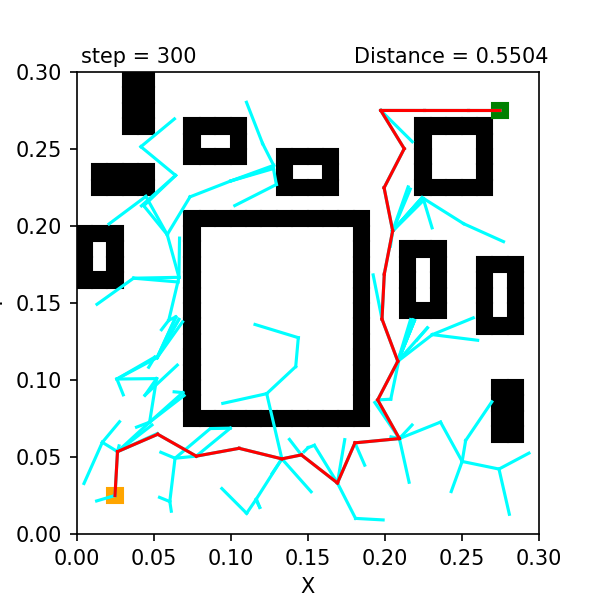

In [11]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    grid_step = np.array([0.01, 0.01])
    grid_num = np.array([30, 30])
    
    map_data = "map.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(RRT(world, ratioPointGoal=0.95))
    
    world.draw()
    #world.ani.save('input.gif', writer='pillow', fps=100)    #Uncomment when you want to save the gif